In [ ]:
!pip install gensim==4.1.2
!pip install scikit-multilearn


     |████████████████████████████████| 24.1 MB 14.8 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 89 kB 4.0 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Start writing code here...
import pandas as pd
import numpy as np
import re
import keras
import time
import matplotlib.pyplot as plt
import seaborn as sns
import nltk.corpus
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords, words
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset, ClassifierChain
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
test_label = pd.read_csv("test_labels.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
# Merging test and train to form one huge dataset
test_data = pd.merge(test, test_label)
dataset = pd.concat([test_data, train])
dataset.drop(columns=['id'], inplace=True)
dataset.drop_duplicates(inplace=True, ignore_index=True)
dataset.drop(dataset.index[dataset['toxic'] == -1], inplace = True)
dataset.reset_index(inplace = True)
df = dataset

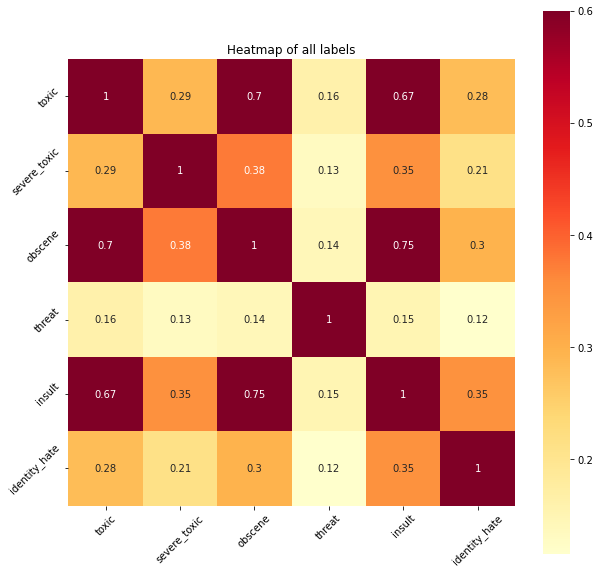

Training Data Comment Breakdown
=====

22468 out of 223549 comments, or 10.05%, are classified as toxic.

21384 toxic comments. (9.57% of all data.)
- 1962 or 9.18% were also severe_toxic.
- 11552 or 54.02% were also obscene.
- 654 or 3.06% were also threat.
- 10686 or 49.97% were also insult.
- 1995 or 9.33% were also identity_hate.

1962 severe_toxic comments. (0.88% of all data.)
- 1962 or 100.00% were also toxic.
- 1880 or 95.82% were also obscene.
- 158 or 8.05% were also threat.
- 1701 or 86.70% were also insult.
- 448 or 22.83% were also identity_hate.

12140 obscene comments. (5.43% of all data.)
- 11552 or 95.16% were also toxic.
- 1880 or 15.49% were also severe_toxic.
- 439 or 3.62% were also threat.
- 8884 or 73.18% were also insult.
- 1570 or 12.93% were also identity_hate.

689 threat comments. (0.31% of all data.)
- 654 or 94.92% were also toxic.
- 158 or 22.93% were also severe_toxic.
- 439 or 63.72% were also obscene.
- 445 or 64.59% were also insult.
- 145 or 21.04% w

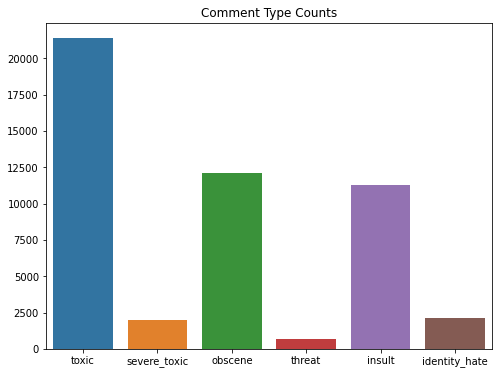

In [ ]:
targets = list(df.columns[2:])
df_targets = df[targets].copy()

# How many rows are toxic? 
toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)


count_dic = {}
for comment_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_targets[(df_targets[comment_type]==1)]
    others.remove(comment_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[comment_type] = counts


del(df_selection)

def heatmap(df, title):
    plt.figure('heatmap', figsize=[10,10])
    plt.title(title)
    df_corr = df.corr()
    #df_corr = np.triu(df_corr, k=1)
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd')
    plt.yticks(rotation = 45)
    plt.xticks(rotation = 45)
    plt.show()

heatmap(df_targets, 'Heatmap of all labels')


print('Training Data Comment Breakdown')
print('=====\n')

print('%d out of %d comments, or %.2f%%, are classified as toxic.' % 
     (np.sum(toxic_rows), len(df), (np.sum(toxic_rows)/len(df))*100))

totals = []
for key, value in count_dic.items():
    totals.append(value[0][1])
    print('\n%d %s comments. (%.2f%% of all data.)' % (value[0][1], key, (value[0][1]/len(df))*100))
    for cnt in value[1:]:
        print('- %d or %.2f%% were also %s.' % (cnt[1], (cnt[1]/value[0][1])*100, cnt[0]))
    

plt.figure('Comment Type Counts', figsize=[8,6])
plt.title('Comment Type Counts')
sns.barplot(x=list(count_dic.keys()), y=totals)
plt.show()

In [ ]:
# Bad comments
for t in targets:
    print("Label: %s ============================================================" % t)
    b = np.where(df_targets[t]==1)[0]
    selection = np.random.choice(b, 10)
    for s in selection:
        print(df.comment_text.loc[s])
        print("++++++++++++")
    print()

Label: toxic ============================================================
Hello. 

Your talk page has been vandalized because you suck dick.
++++++++++++
because i didnt do anything wrong in the first place..you accused me of doing something i didnt so i thought i would just in spite..but harrassement is absolutely pathetic..talking crud.
++++++++++++
" 
 :Because, stupid me, I thought I try and do the right thing, even though time was short. More fool me, eh? '''''' "
++++++++++++
WE HATE YOU ITALIANS! DIE DIE DIE!
++++++++++++
|unblock| all of you can suck my dick
++++++++++++
sup 

Thanks for the anal sex yesterday!

Love,
George (your homosexual lover)
++++++++++++
Ah Tbhotch you stupid little prick !!!
++++++++++++
What we at Toho Kingdom RULE! Shut up!
++++++++++++
I will flay you alive, you fking stalker. 

I shall enjoy your screams of agony as your blood slowly pools across the floor of my basement.
++++++++++++
are you kidding me. with half of this crap on here that is just p

In [ ]:
# Clean comments
targets.append('any_label')
df_targets['any_label'] = toxic_rows

b = np.where(df_targets.any_label==0)[0]
selection = np.random.choice(b, 10)
print("Clean comments =========================================")
for s in selection:
    print(df.comment_text.loc[s])
    print("++++++++++++")

Clean comments =========================================
"
 The POV was ""refused to"".  The car and the name of the house are trivial, irrelevant details.  ""Wee curry monster"" has reverted these changes with no sensible explanation at all.  It's not a content dispute, really - he's simply reverting in an attempt to attack me.  190.46.108.141  "
++++++++++++
Regarding edits made during March 11 2007 (UTC)
Please do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you.  If this is an IP address, and it is shared by multiple users, ignore this warning if you did not make any unconstructive edits. Silver
++++++++++++
Can you give an example of a social scientist who agrees or disagrees?
++++++++++++
I don't think the formula, , is explained in either of the references, so perhaps this should just justified better in the article, or an appropriate reference added.
++++++++++++
"

 The Raven - resource link 

  

Hi, can yo

In [ ]:
b = np.where(df_targets[t]==0)[0]
selection = np.random.choice(b, 10)
print("Clean comments =========================================")
for s in selection:
    print(df.comment_text.loc[s])
    print("++++++++++++")

Clean comments =========================================
Well, lucky for us that your status as a community pariah means that your opinion, esp in this topic area, is pretty much ignored.  Due to the ongoing campaign of harassment against the subject, harassment that is also occurring on this page and others by socks and SPAs, the level of increased protection is quite justified.
++++++++++++
" 

 :The whole article kind of sucks, overlarge sections are the least of its problems.  Personally, I'd love to see ALL these ""horse racing in country X sections tossed into some other article altogether (like ""list of race tracks in country X"")  and this be an overview of horse racing generally.   "
++++++++++++
RGloucester – Previously you took a very active administrator role regarding Ukraine crisis issue. Am I right in assuming you have now completely disavowed your role as an administrator on Ukraine issues?
++++++++++++
:Regarding #3, the article in its neutral form does say that the o

In [ ]:
df['length'] = df.comment_text.apply(lambda x: len(x))
print("Average toxic comment length: %d" % int(np.mean(df[(df_targets.any_label==1)].length)))
print("Average clean comment length: %d" % int(np.mean(df[(df_targets.any_label==0)].length)))
print()
print("Median toxic comment length: %d" % int(np.median(df[(df_targets.any_label==1)].length)))
print("Median clean comment length: %d" % int(np.median(df[(df_targets.any_label==0)].length)))

Average toxic comment length: 286
Average clean comment length: 402

Median toxic comment length: 118
Median clean comment length: 215


In [ ]:
def pct_caps(s):
    return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))
print("Percent of capitalized characters in toxic comments: %d%%" % int(100 * np.mean(df[(df_targets.any_label==1)].caps)))
print("Percent of capitalized characters in clean comments: %d%%" % int(100 * np.mean(df[(df_targets.any_label==0)].caps)))

Percent of capitalized characters in toxic comments: 14%
Percent of capitalized characters in clean comments: 6%


In [ ]:
def word_length(s):
    s = s.split(' ')
    return np.mean([len(w) for w in s if w.isalpha()])
df['word_length'] = df.comment_text.apply(lambda x: word_length(x))

print("Average word length in toxic comments: %.1f" % np.mean(df[(df_targets.any_label==1)].word_length))
print("Average word length in clean comments: %.1f" % np.mean(df[(df_targets.any_label==0)].word_length))

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Average word length in toxic comments: 4.2
Average word length in clean comments: 4.4


In [ ]:
df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))
print("Exclamations in toxic comments: %.1f" % np.mean(df[(df_targets.any_label==1)].exclamation))
print("Exclamations in clean comments: %.1f" % np.mean(df[(df_targets.any_label==0)].exclamation))
print()
df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))
print("Question marks in toxic comments: %.1f" % np.mean(df[(df_targets.any_label==1)].question))
print("Question marks in clean comments: %.1f" % np.mean(df[(df_targets.any_label==0)].question))

Exclamations in toxic comments: 3.7
Exclamations in clean comments: 0.4

Question marks in toxic comments: 0.5
Question marks in clean comments: 0.4


### Label overlap summary: percentage and graph

In [ ]:
import re
ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
def strip_ip(s, ip):
    try:
        found = ip.search(s)
        return s.replace(found.group(), ' ')
    except:
        return s
    
df.comment_text = df.comment_text.apply(lambda x: strip_ip(x, ip))

Label overlap summary.
1 label: 36.5%
2 labels: 22.3%
3 labels: 28.0%
4 labels: 10.6%
5 labels: 2.4%
6 labels: 0.2%


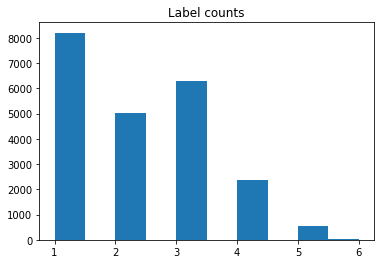

In [ ]:
target_sums = np.sum(df_targets[df_targets.columns[:-1]], axis=1)
target_sums = target_sums[(df_targets.any_label==1)]
plt.figure('Label counts')
plt.title('Label counts')
plt.hist(target_sums)
print("Label overlap summary.")
for i in range(1,7):
    print('%d label%s: %.1f%%' % (i, 's' if i > 1 else '', 100 * len([s for s in target_sums if s == i])/len(target_sums)))

### Split Labels from Training Data

In [ ]:
print('Training labels:')
print(list(df_targets.columns))
print(df_targets.shape)

print('\nTraining data: ')
print(list(df.columns))
print(df.shape)

Training labels:
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'any_label']
(223549, 7)

Training data: 
['index', 'comment_text', 'length', 'caps', 'word_length', 'exclamation', 'question']
(223549, 7)


### Visualize Word Counts

In [ ]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from nltk.corpus import stopwords
import string

top_words = 5000
tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True, num_words=top_words)
tokenizer.fit_on_texts(df['comment_text'])
df['comment_sequence'] = tokenizer.texts_to_sequences(df.comment_text.str.lower())

In [ ]:
def get_word_cnt(tokenizer):
    word_cnt = [(k, v) for k, v in zip(tokenizer.word_counts.keys(), 
                                       tokenizer.word_counts.values())]
    word_cnt.sort(key = lambda tup: tup[1], reverse=True)
    stopWords = set(stopwords.words('english'))
    word_cnt = [tup for tup in word_cnt if tup[0] not in stopWords]
    return word_cnt

def word_plot(word_cnt, num_words, title):
    plt.figure(title, figsize=(24, 12))
    plt.suptitle(title, fontsize=40)
    sns.barplot(x= [tup[0] for tup in word_cnt[0:num_words]], 
                y = [tup[1] for tup in word_cnt[0:num_words]])
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, rotation=35, ha='right')
    plt.show()

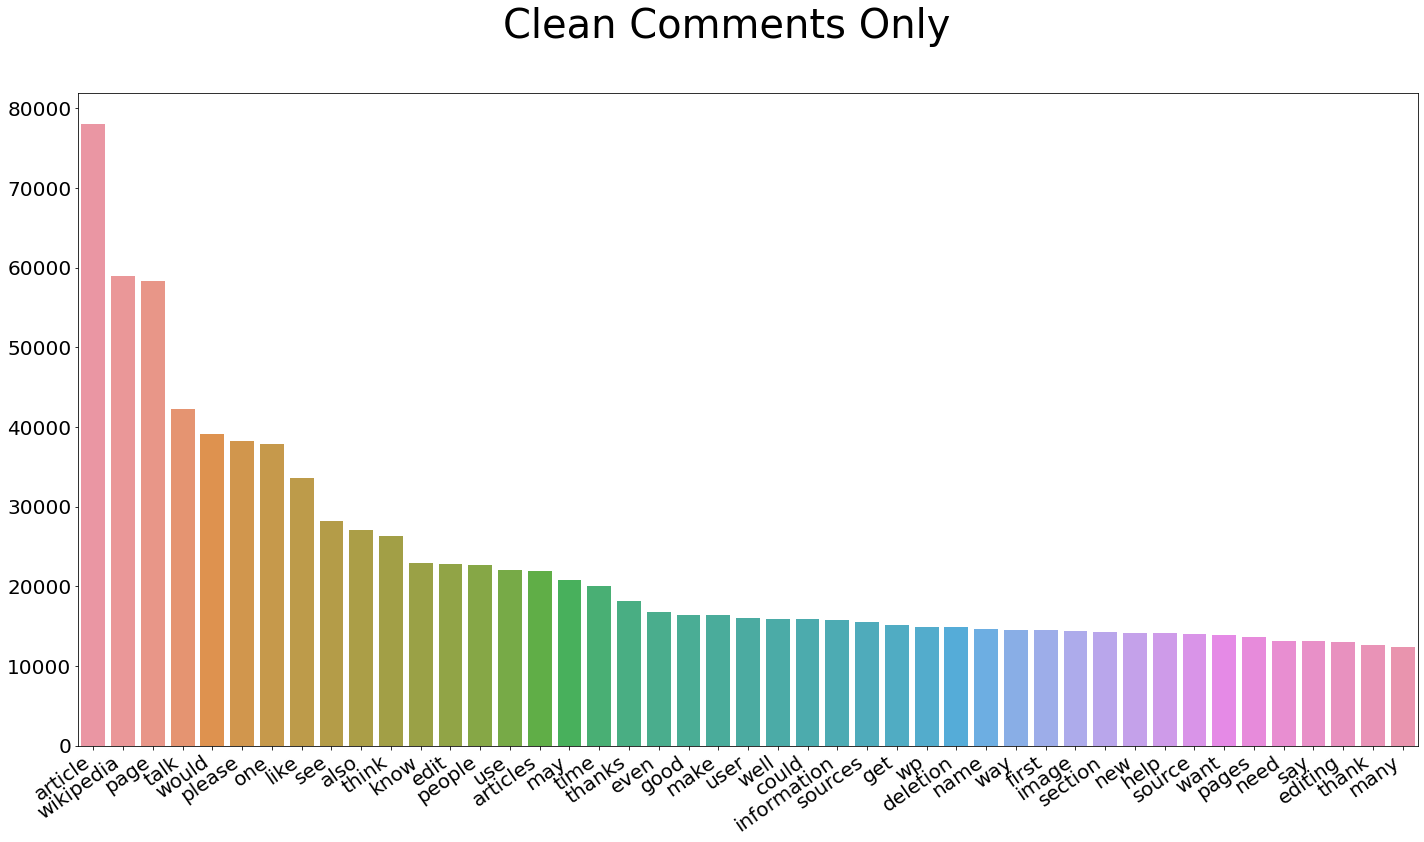

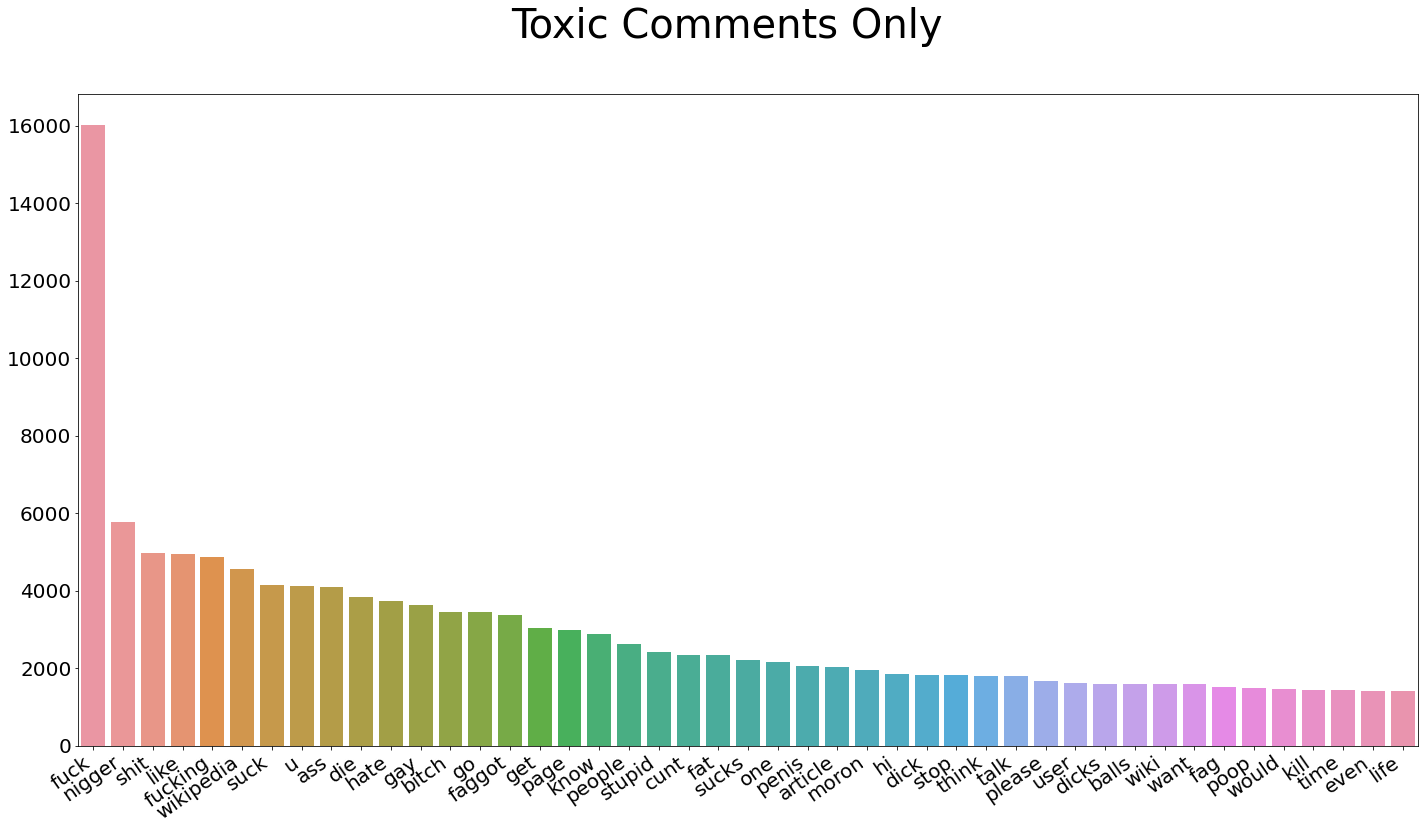

In [ ]:
all_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
all_tokenizer.fit_on_texts(df.comment_text[(toxic_rows==0)])
word_plot(get_word_cnt(all_tokenizer), 45, 'Clean Comments Only')
    
toxic_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
toxic_tokenizer.fit_on_texts(df.comment_text[toxic_rows])
word_plot(get_word_cnt(toxic_tokenizer), 45, 'Toxic Comments Only')

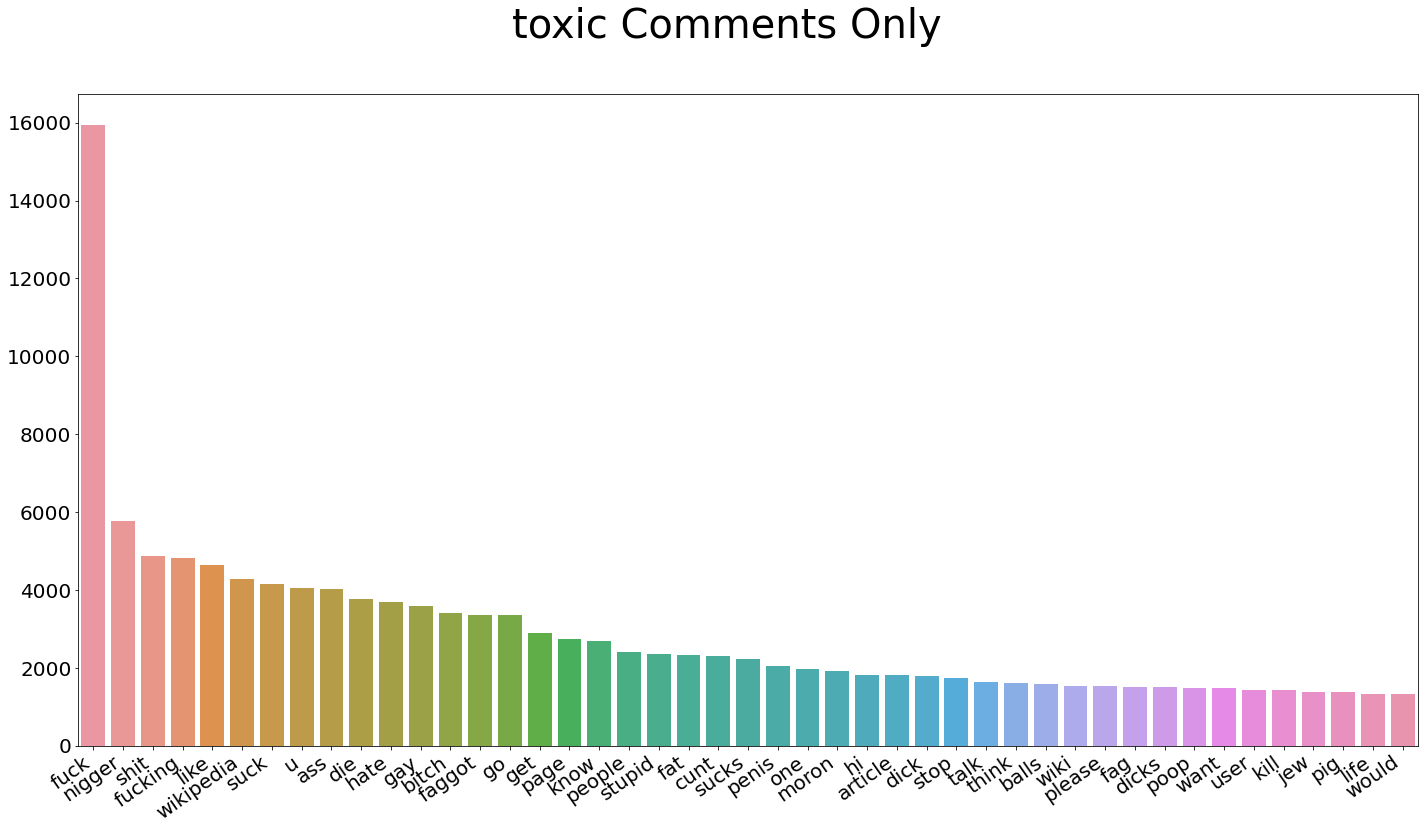

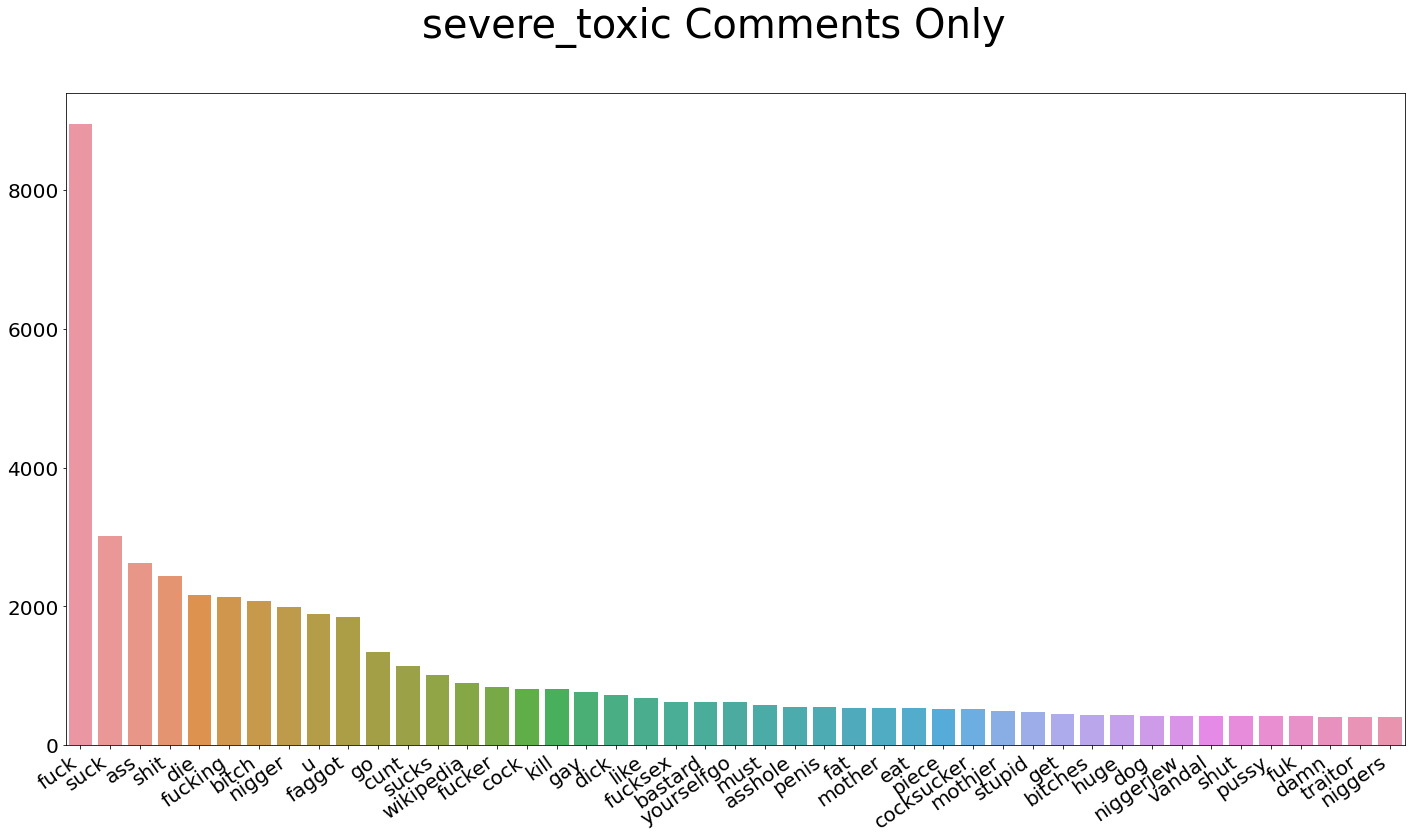

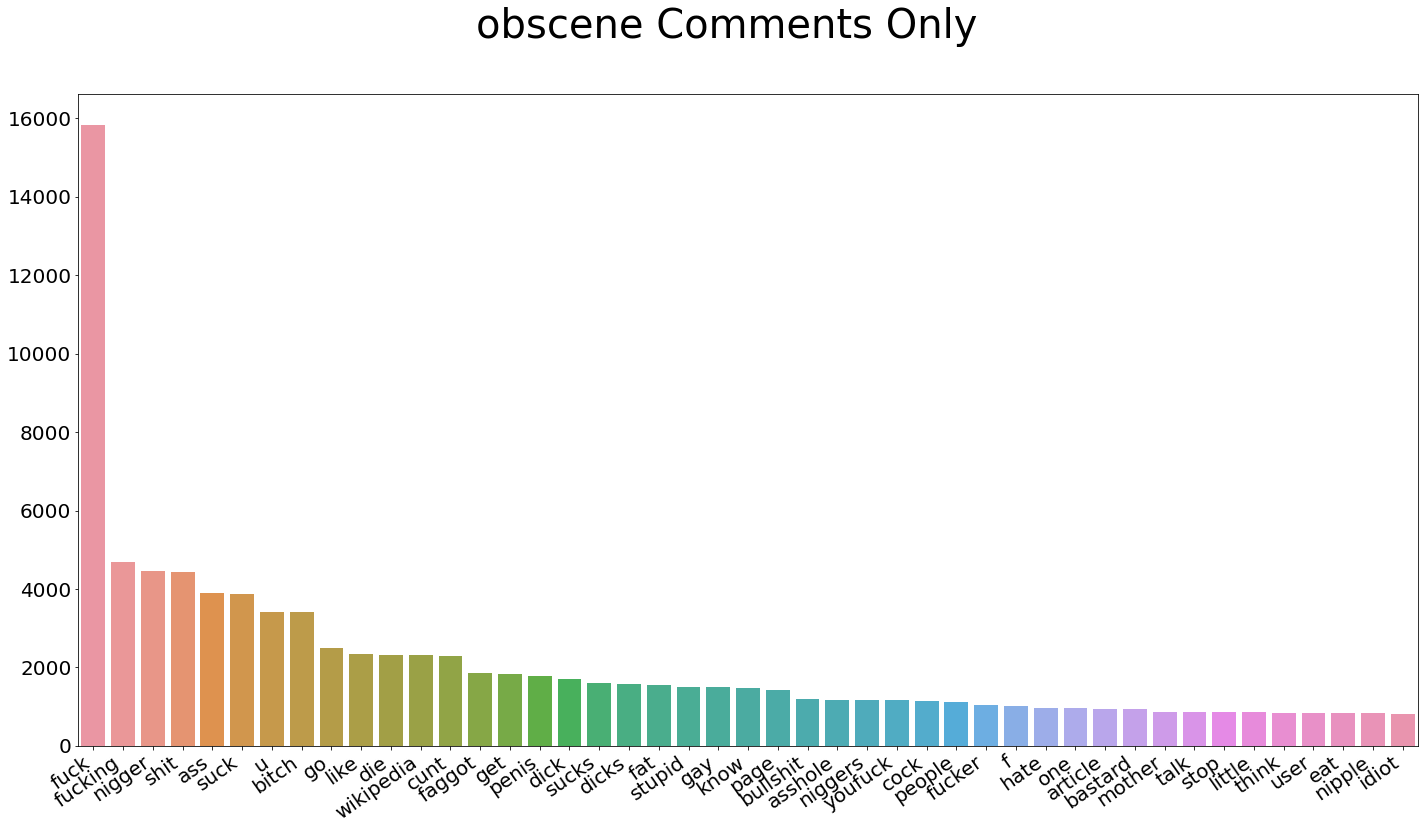

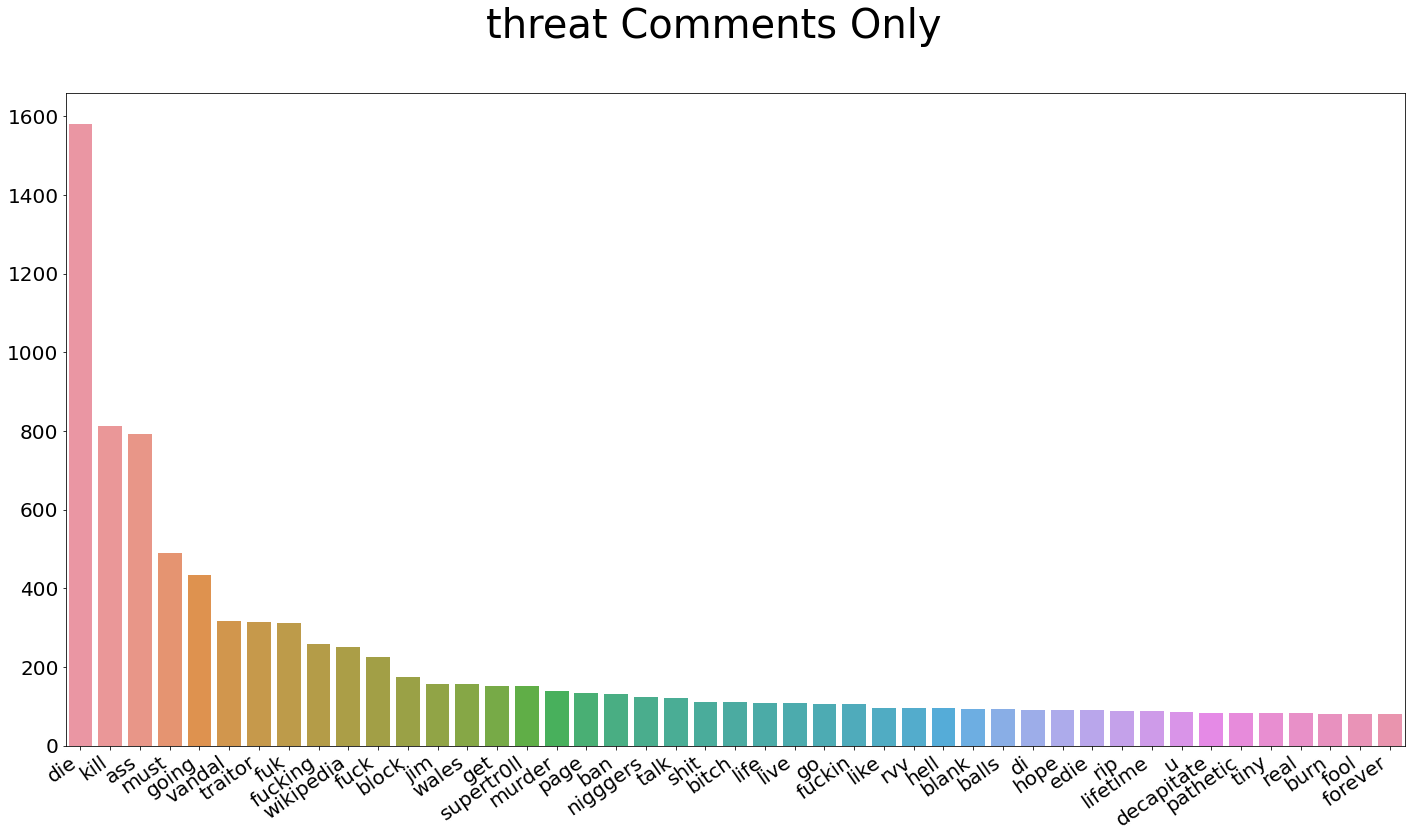

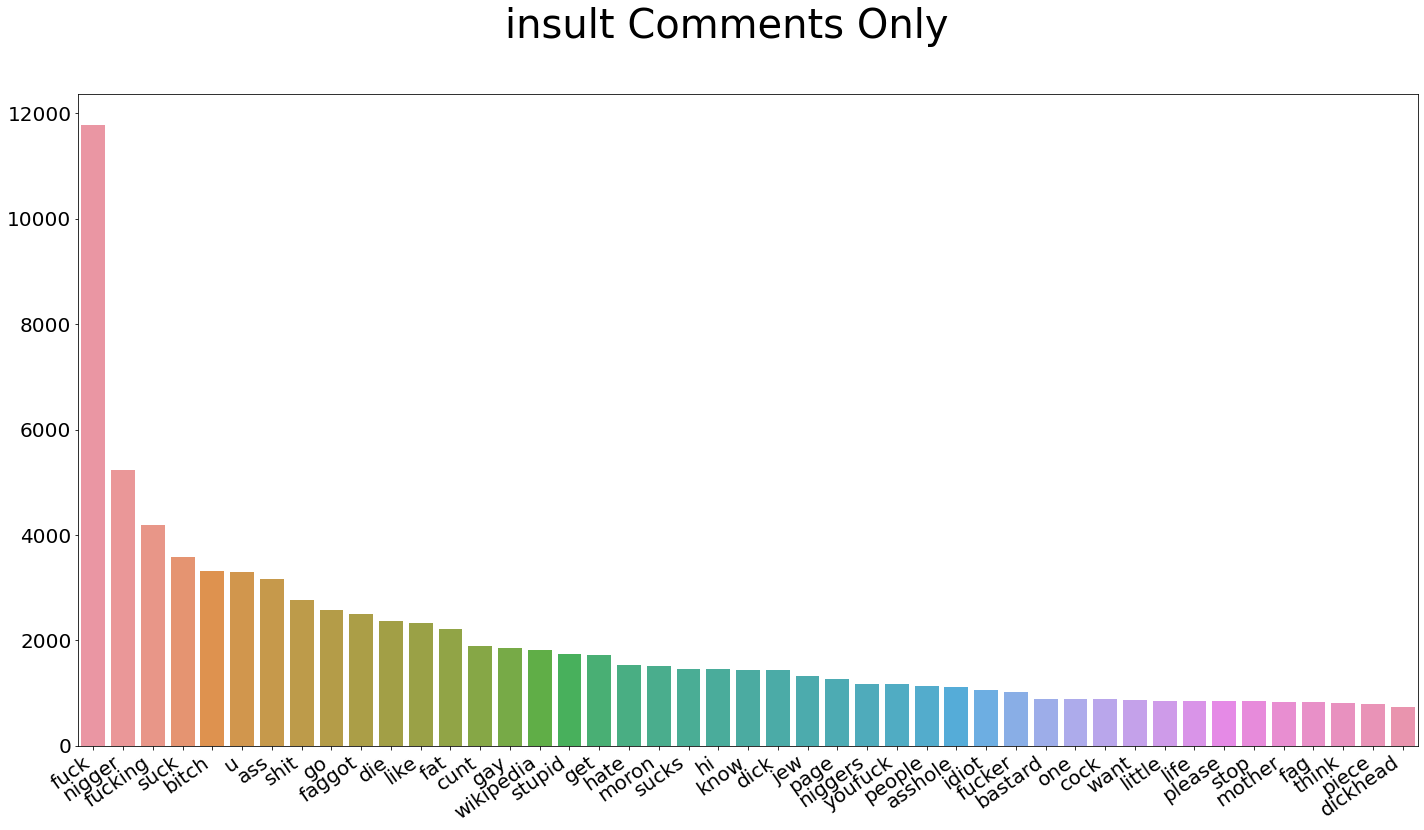

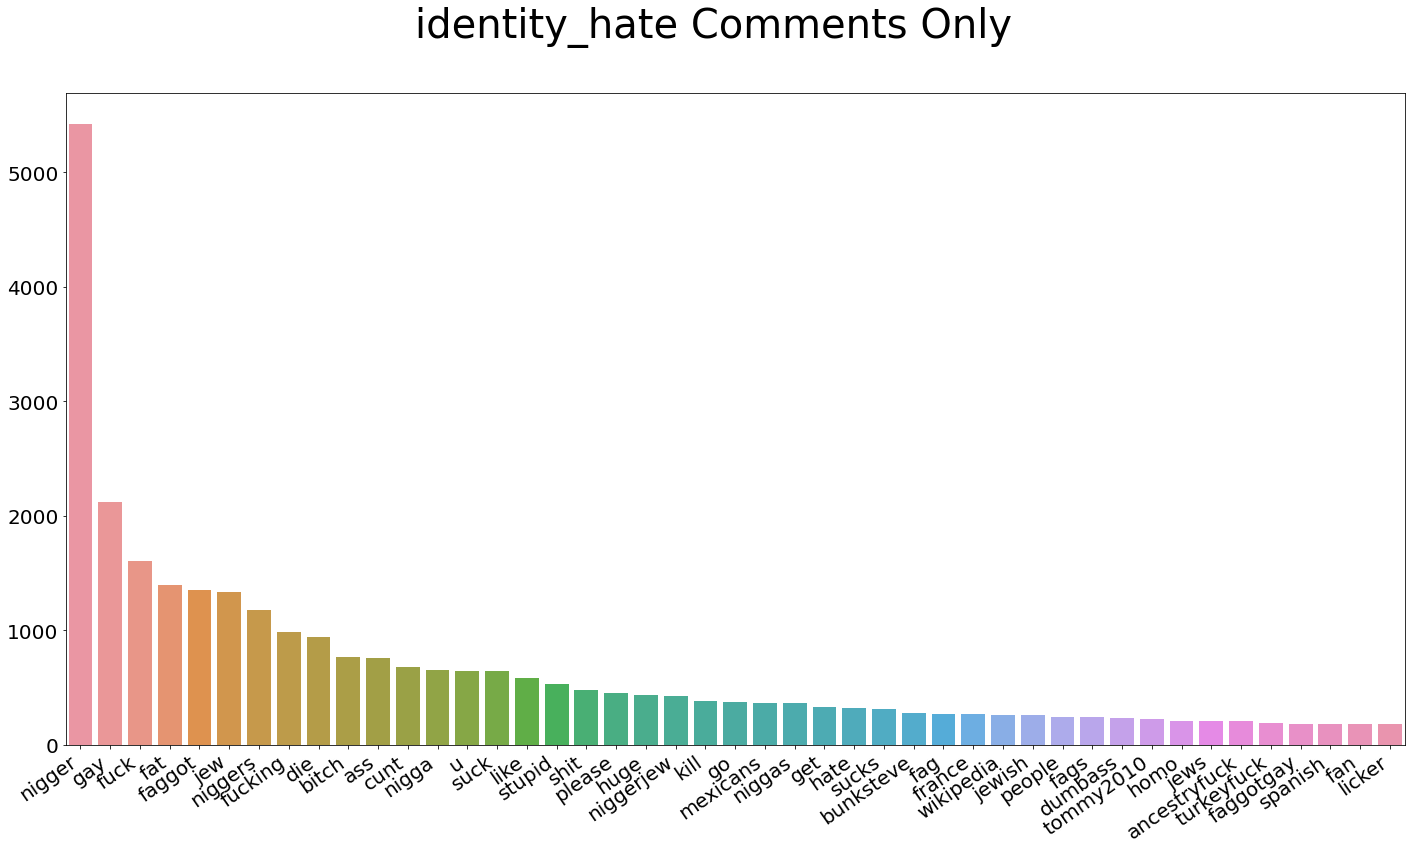

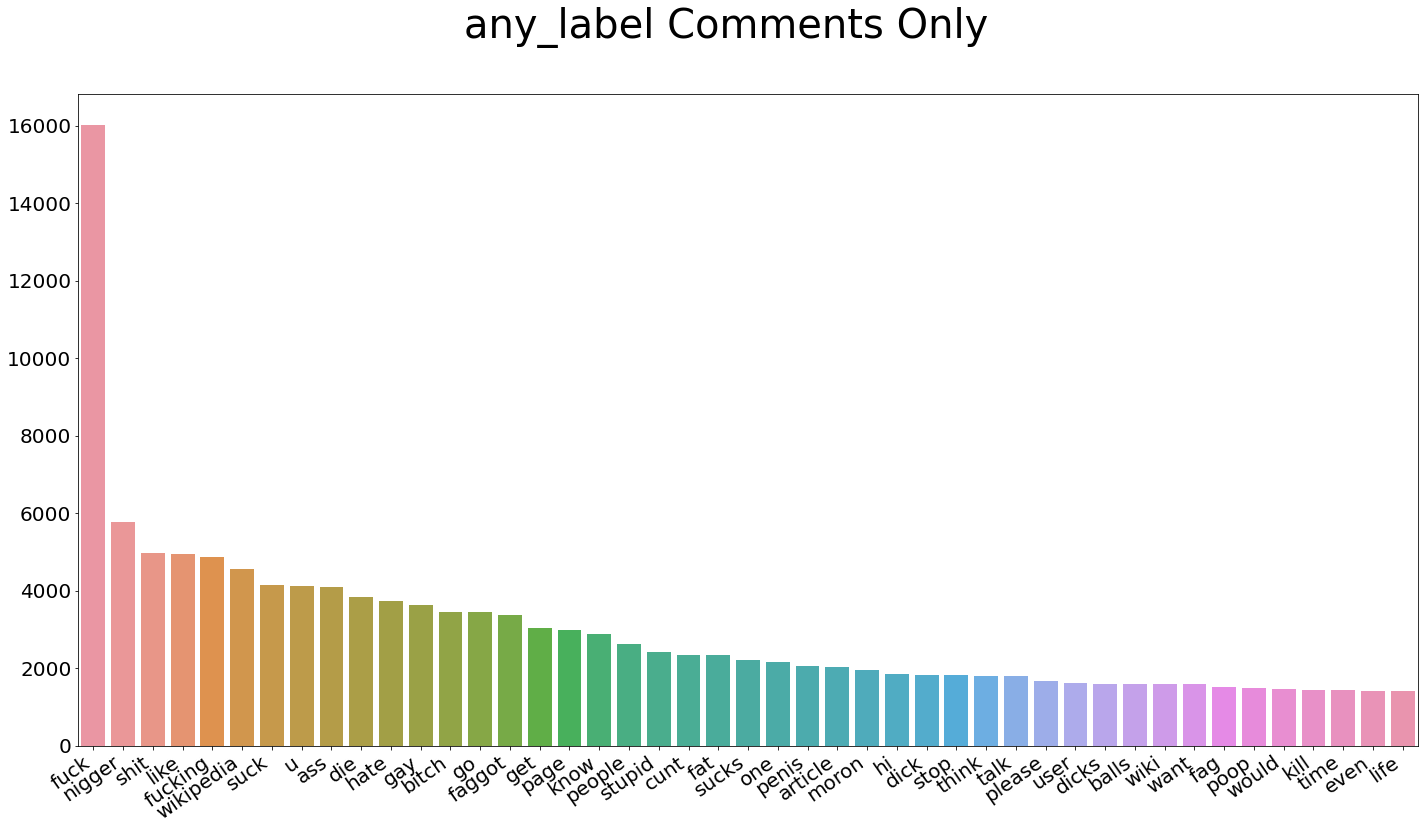

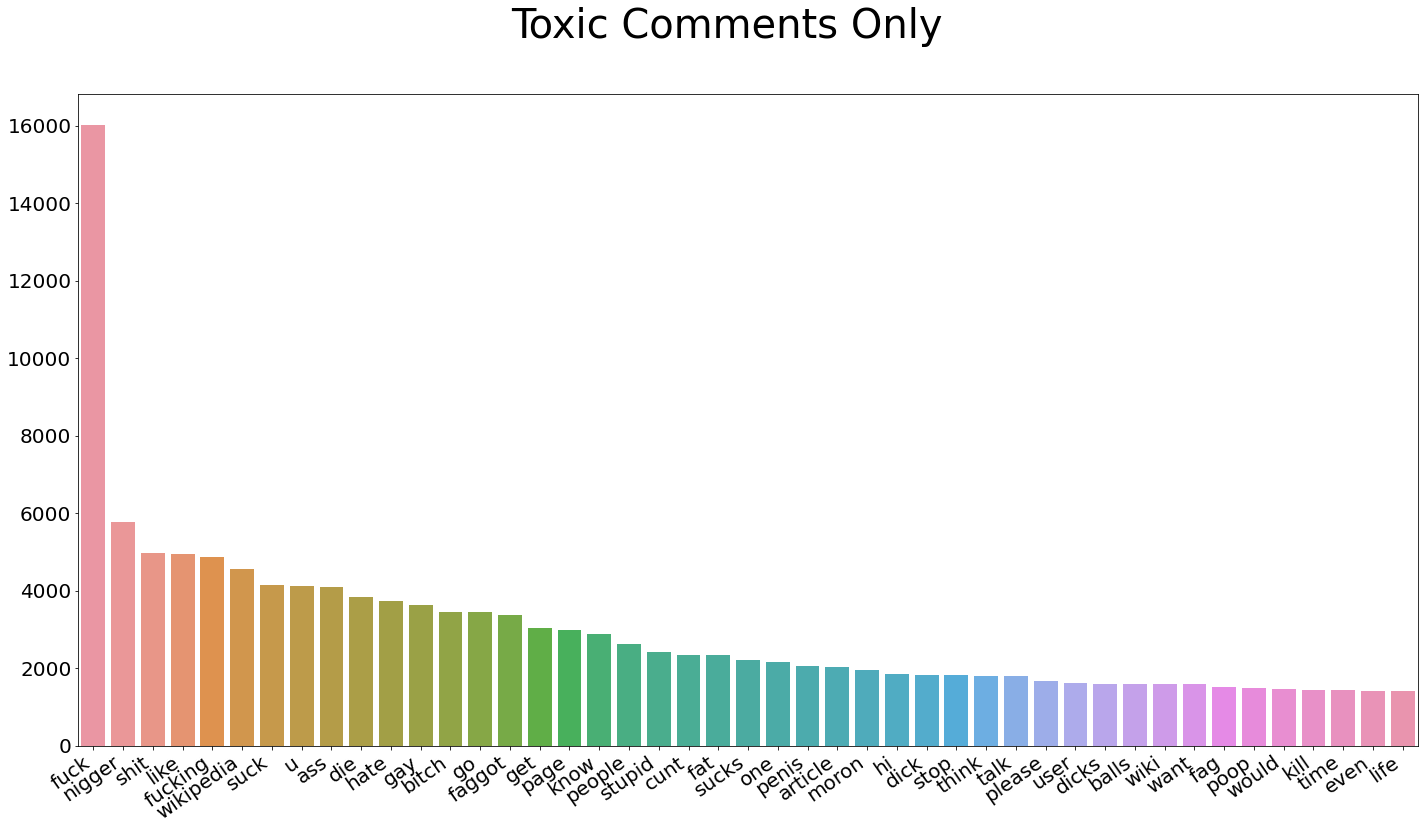

In [ ]:
for label in targets:
    toxic_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
    toxic_tokenizer.fit_on_texts(df.comment_text[(df_targets[label]==1)])
    word_plot(get_word_cnt(toxic_tokenizer), 45, label + ' Comments Only')

In [ ]:
pip install wordcloud

     |████████████████████████████████| 366 kB 21.1 MB/s 
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


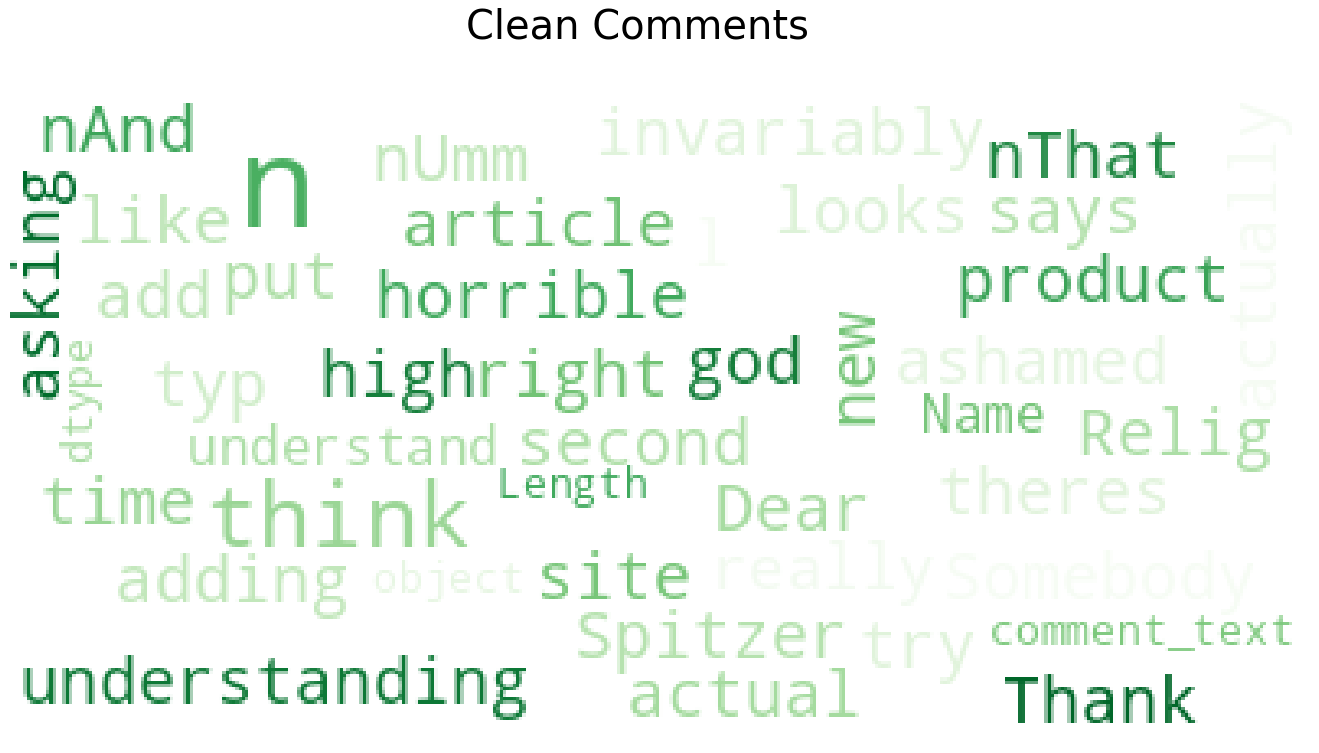

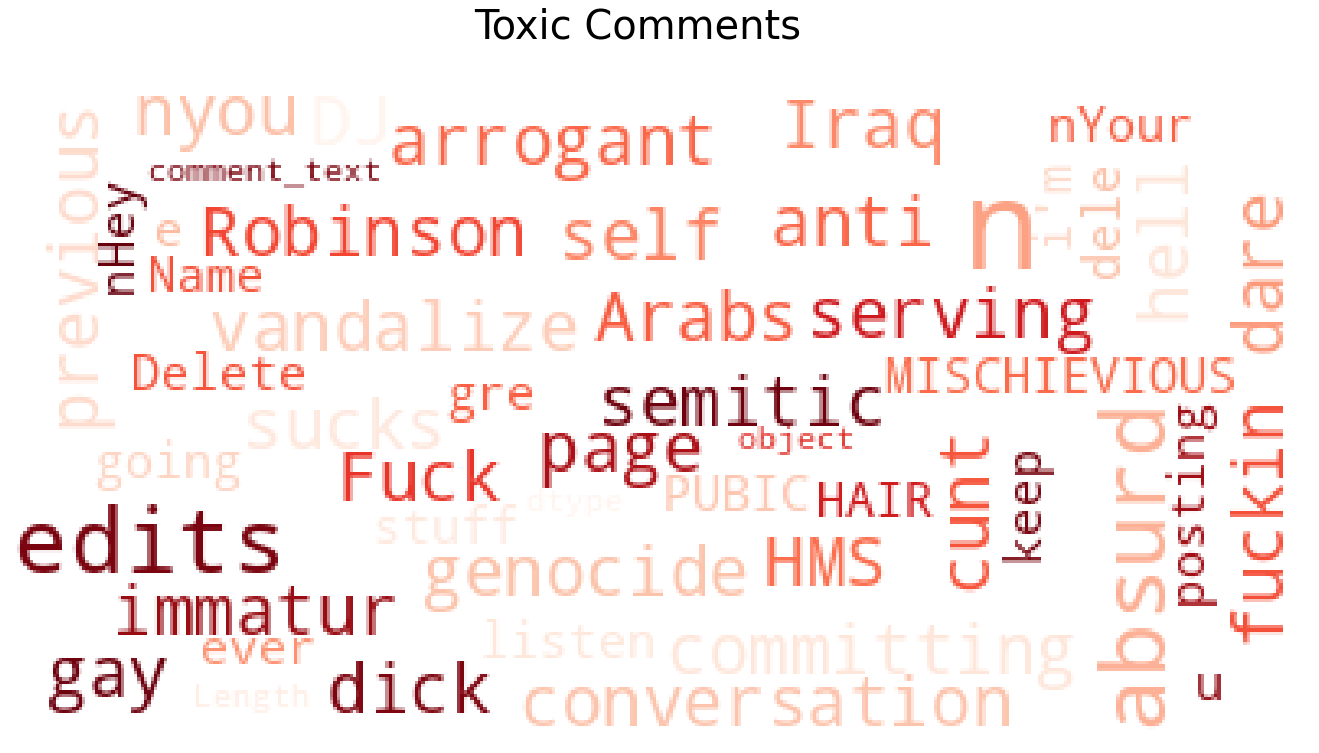

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                      stopwords=set(stopwords.words('english')),
                      max_words=100,
                      max_font_size=40,
                      colormap='Greens'
                         ).generate(str(df.comment_text[(toxic_rows==0)]))
plt.figure('wordcloud', figsize=(24,12))
plt.suptitle('Clean Comments', fontsize=40)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud = WordCloud(background_color='white',
                      stopwords=set(stopwords.words('english')),
                      max_words=100,
                      max_font_size=40,
                      colormap='Reds'
                         ).generate(str(df.comment_text[toxic_rows]))
plt.figure('toxic_wordcloud', figsize=(24,12))
plt.suptitle('Toxic Comments', fontsize=40)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=76d5da57-bc03-4256-b97a-d71842b03104' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>